In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import tarfile
tar = tarfile.open("drive/My Drive/Datasets/Dataset.tar.gz")
tar.extractall()
tar.close()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from PIL import Image
import os

import torchvision.transforms as trf

from IPython.display import clear_output as clr
import matplotlib.pyplot as plt

from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import cv2

import cv2
import numpy as np
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import sys
import torch.nn.init
import os
from IPython.display import clear_output as clr

In [2]:
class Block(nn.Module):
    def __init__(self, in_filters, out_filters, seperable=True):
        super(Block, self).__init__()
        
        if seperable:
            
            self.spatial1=nn.Conv2d(in_filters, in_filters, kernel_size=3, groups=in_filters, padding=1)
            self.depth1=nn.Conv2d(in_filters, out_filters, kernel_size=1)
            
            self.conv1=lambda x: self.depth1(self.spatial1(x))
            
            self.spatial2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1, groups=out_filters)
            self.depth2=nn.Conv2d(out_filters, out_filters, kernel_size=1)
            
            self.conv2=lambda x: self.depth2(self.spatial2(x))
            
        else:
            
            self.conv1=nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
            self.conv2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
        
        self.batchnorm1=nn.BatchNorm2d(out_filters)
        self.batchnorm2=nn.BatchNorm2d(out_filters)

    def forward(self, x):
        
        x=self.batchnorm1(self.conv1(x)).clamp(0)
        
        x=self.batchnorm2(self.conv2(x)).clamp(0)
        
        return x

In [3]:
class UEnc(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        super(UEnc, self).__init__()
        
        self.enc1=Block(in_chans, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
 
        self.middle=Block(8*ch_mul, 16*ch_mul)
  
  
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, squeeze, kernel_size=(1, 1))
        
    def forward(self, x):
        
        enc1=self.enc1(x)
        
        enc2=self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3=self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4=self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle=self.middle(F.max_pool2d(enc4, (2,2)))
        
        
        up1=torch.cat([enc4, self.up1(middle)], 1)
        dec1=self.dec1(up1)
        
        up2=torch.cat([enc3, self.up2(dec1)], 1)
        dec2=self.dec2(up2)
        
        up3=torch.cat([enc2, self.up3(dec2)], 1)
        dec3=self.dec3(up3)
        
        up4=torch.cat([enc1, self.up4(dec3)], 1)
        dec4=self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final

In [4]:
class Classify(nn.Module):
   def __init__(self, num_classes=64, in_chans=3):
        super(Classify, self).__init__()
        
#         self.classify1 = nn.Conv2d(in_chans, 256, kernel_size=(1, 1))
#         self.act = nn.LeakyReLU()
#         self.classify2 = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
        self.classify2 = nn.Conv2d(in_chans, num_classes, kernel_size=(1, 1))

        
   def forward(self, x):

#         return self.classify2(self.act(self.classify1(x)))
        return x    

In [5]:
class UDec(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        super(UDec, self).__init__()
        
        self.enc1=Block(squeeze, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, 1, kernel_size=(1, 1))
        
    def forward(self, x):
        
        enc1 = self.enc1(x)
        
        enc2 = self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3 = self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4 = self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle = self.middle(F.max_pool2d(enc4, (2,2)))
        
        
        up1 = torch.cat([enc4, self.up1(middle)], 1)
        dec1 = self.dec1(up1)
        
        up2 = torch.cat([enc3, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)
        
        up3 = torch.cat([enc2, self.up3(dec2)], 1)
        dec3 =self.dec3(up3)
        
        up4 = torch.cat([enc1, self.up4(dec3)], 1)
        dec4 = self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final

In [6]:
class WNet(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3, out_chans=1000, num_classes = 300):
        super(WNet, self).__init__()
        if out_chans==1000:
            out_chans=in_chans
        self.UEnc=UEnc(squeeze, ch_mul, in_chans)
        self.UDec=UDec(squeeze, ch_mul, out_chans)
        self.Class = Classify(num_classes, squeeze)
    def forward(self, x, returns='both'):
        
        enc = self.UEnc(x)
        cla = self.Class(enc)
        
        if returns=='enc':
            return enc, cla
        
        dec=self.UDec(F.softmax(enc, 1))
        
        if returns=='dec':
            return dec
        
        if returns=='both':
            return enc, dec, cla
        
        else:
            raise ValueError('Invalid returns, returns must be in [enc dec both]')

In [7]:
def dense_brightness_weight(img, sigma_X = 4, sigma_I = 10, r = 5):
    """
    Calculate bright_weight(connection) for image
    
    Args:
        image: ndarray [B,H,W,C].
        sigma_X: sigma for metric of distance.
        sigma_I: sigma for metric of intensity.
        r: radius of circle that only the neighbor in circle is considered.
    Returns:
        brightness_weight: ndarray [B, W*H, W*H]
    """
    
    B,N,M,C = img.shape
    
    image = img.cpu().numpy()
    weight_size = N*M
    batch_size = image.shape[0]
    bright_weights = np.zeros((batch_size,weight_size,weight_size))
    reduce_image = np.mean(image,axis = 3)
    
#     print(bright_weights.shape, reduce_image.shape)
    
    for batch in range(batch_size):
        # Reduce channel
        flat_image = np.ravel(reduce_image[batch])
        
        # Gaussian neighbor
        Fj, Fi = np.meshgrid(flat_image, flat_image)
        X, Y = list(zip(*np.ndindex(image.shape[1:3])))
        Xj, Xi = np.meshgrid(X,X)
        Yj, Yi = np.meshgrid(Y,Y)
        X_metric = np.sqrt((Xi - Xj)**2 + (Yi - Yj)**2)
        F_metric = np.abs(Fi - Fj)
        
        # Brightness weight
        bright_weight = np.exp(-(X_metric**2 / sigma_X**2) -(F_metric**2 / sigma_I**2))
        bright_weight[X_metric >= r] = 0
        bright_weights[batch] = bright_weight
        
    return bright_weights

In [ ]:
def soft_ncut(img, cla):

    '''
    img : B x C x N x M
    cla : B x K x N x M
    '''


    B, C, N, M = img.shape
    K = cla.shape[1]
    weight_size = N*M

    cla = cla.view(B,K,N*M)
    img = torch.stack([img.transpose(0,3).transpose(1,2)[:,:,:,0]])
#     print(img.shape)
    image_weights = dense_brightness_weight(img)
    sum_image_weights = np.sum(image_weights,axis=-1)
    dis_assoc = torch.zeros((B,K))
    assoc = torch.zeros((B,K))
    for batch in range(B):
        # [K, H*W] @ [H*W, H*W] = [K, H*W]
        W_Ak = torch.mm(cla[batch], torch.tensor(image_weights[batch]).float().cuda()) # [K, H*W]
        dissoc = torch.mm(W_Ak, cla[batch].transpose(0,-1)) # [K, K]
        dis_assoc[batch] = torch.diag(dissoc) # [K]
        vec = torch.tensor(sum_image_weights[batch]).float().cuda()
        assoc[batch] = torch.matmul(cla[batch], vec) # [K]
    eps = 0.0000001
    soft_ncut = K - torch.sum((dis_assoc + eps) / (assoc + eps), 1)
    return soft_ncut

In [ ]:
vertical_sobel=torch.nn.Parameter(torch.from_numpy(np.array([[[[1,  0,  -1], 
                                            [1,  0,  -1], 
                                            [1,  0,  -1]]]])).float().cuda(), requires_grad=False)
horizontal_sobel=torch.nn.Parameter(torch.from_numpy(np.array([[[[1,   1,  1], 
                                              [0,   0,  0], 
                                              [-1 ,-1, -1]]]])).float().cuda(), requires_grad=False)


n_segments = 500
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

def gradient_regularization(softmax, device='cuda'):
    vert=torch.cat([F.conv2d(softmax[:, i].unsqueeze(1), vertical_sobel) for i in range(softmax.shape[0])], 1)
    hori=torch.cat([F.conv2d(softmax[:, i].unsqueeze(1), horizontal_sobel) for i in range(softmax.shape[0])], 1)
    print('vert', torch.sum(vert))
    print('hori', torch.sum(hori))
    mag=torch.pow(torch.pow(vert, 2)+torch.pow(hori, 2), 1)
    mean=torch.mean(mag)
    return mean
  
def ncut_cons_loss(img, cla):
    
    img = img.transpose(0,3).transpose(1,2).transpose(1,0).cpu().data.numpy()[:,:,:,0]
    
    labels1 = segmentation.slic(img, compactness=30, n_segments=n_segments)
#     g = graph.rag_mean_color(img, labels1, mode='similarity')
#     labels2 = graph.cut_normalized(labels1, g, thresh=0.05)
    labels2 = labels1
    
    
    _, classes  = torch.max(cla,1)
#     classes = torch.reshape(classes, (labels2.shape[0],))
    
#     print(classes.shape, labels2.shape, labels1.shape, img.shape)
    loss = loss_fn(cla.view(1,n_segments,-1), torch.tensor(labels2).view(1,-1).cuda())
    
#     print(out2.shape, enc.shape)
    return loss

def train_op(model, optimizer, input, psi=0.9):
    enc, cla = model(input, returns='enc')
#     print(cla.shape)
    sobel_loss = gradient_regularization(enc)*psi/50
#     n_cut_loss2 = ncut_cons_loss(input, enc)*psi
#     n_cut_loss = n_cut_loss1 + n_cut_loss2

    n_cut_loss = soft_ncut(input, cla)*psi

    n_cut_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    dec = model(input, returns='dec')
    rec_loss=torch.mean(torch.pow(torch.pow(input -  dec, 2), 1))*(1-psi)
    rec_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(n_cut_loss, rec_loss)
    return model

def test():
    wnet=WNet(n_segments, num_classes = n_segments)
    wnet=wnet.cuda()
    synthetic_data=torch.rand((1, 3, 96, 96)).cuda()
    optimizer=torch.optim.SGD(wnet.parameters(), 0.001)
    train_op(wnet, optimizer, synthetic_data)

In [27]:
torch.cuda.empty_cache()
test()

tensor([453.9581], grad_fn=<MulBackward0>) tensor(0.0488, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
def train(frame1 , frame2):
  prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  hsv = np.zeros_like(frame1)
  hsv[...,1] = 255

  # while(1):
  next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prvs, next, None,0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
  
  datav = torch.from_numpy( np.array([frame2.transpose( (2, 0, 1) ).astype('float32')/255.]) )
  datav = Variable(datav)
  if (use_cuda):
    datav = datav.cuda()
  labels1 = segmentation.slic(rgb, compactness=30, n_segments=400)
  out1 = color.label2rgb(labels1, rgb, kind='avg')
  g = graph.rag_mean_color(rgb, labels1, mode='similarity')
  labels2 = graph.cut_normalized(labels1, g,thresh=0.5)
  out2 = color.label2rgb(labels2, frame2, kind='avg')

  edges = cv2.Canny(frame2,50,300)
  
  input = datav#torch.stack([torch.tensor(frame2)]).cuda()
  
  for batch_idx in range(max_iter): #1000 is max iters
      # forwarding
      optimizer.zero_grad()
      enc, cla = model(input, returns='enc')
      
      sobel_loss = gradient_regularization(enc)*psi/50
      
      
      n_cut_loss = soft_ncut(input, cla)*psi


      dec = model(input, returns='dec')
      rec_loss=torch.mean(torch.pow(torch.pow(torch.tensor(edges).view(1, edges.shape[0],edges.shape[1]).float().cuda() -  dec, 2), 1))
      
#       print(n_cut_loss, rec_loss)
      target = labels2
      target=torch.tensor(target)
      
      mask=torch.tensor((out2[:,:,0]!=0)*1)
      mask=mask.view(mask.shape,500).float()
      target = Variable( target )
      
      if(use_cuda):
        mask = mask.cuda()
        target = target.cuda()
      
      output = enc
      masked_out = (enc*mask)
      masked_tar = (target.float()*mask).view(1,edges.shape[0],edges.shape[1])
   
  
#       print(output.shape)
      loss1 = loss_fn(masked_out, masked_tar.to(dtype = torch.int64)).cuda()
      loss2 = soft_ncut(datav, output).cuda()*psi
      loss = loss1.cuda() + loss2.cuda() + n_cut_loss.cuda()*0 + rec_loss.cuda()*0.00001 + sobel_loss.cuda()*0.00001
#       loss += loss_mse(edge_preds[0][0], torch.tensor(edges).float().cuda())*0.001
      loss.backward()
      optimizer.step()
      
      print (batch_idx, '/',max_iter, ':', loss1.data, loss2.data, n_cut_loss.data, rec_loss.data, sobel_loss.data)

In [14]:
wnet=WNet(500)
# wnet=wnet.cuda()
optimizer=torch.optim.Adam(wnet.parameters(), 0.001)
torch.cuda.empty_cache()
model= wnet
model.load_state_dict(torch.load('model.h5', map_location = 'cpu'))

In [53]:
max_iter = 1
psi = 0.01
use_cuda = True
for epochs in range(50):
  psi = epochs*0.0001
  for num in [1,2,3,4,5]:
    path1 = './Dataset/camera'+str(num)+'/JPEGImages'
    folder_path = path1
    rand = np.random.randint(300)
    file_names = sorted(os.listdir(folder_path))[rand:rand+10]
    file_index = 0
    num_images = len(file_names)
    batch_size = 1
    
    for batch_number in range(0,num_images // batch_size - 1):
      batch = []
      for i in range(0,batch_size):
        filename = os.path.join(folder_path, file_names[file_index])
        filename2 = os.path.join(folder_path, file_names[file_index+1])

        frame1 = cv2.resize(cv2.imread(filename), (64,64))
        frame2 = cv2.resize(cv2.imread(filename2), (64,64))
        
        torch.cuda.empty_cache()
        train(frame1, frame2)
      
      print("Epoch:",epochs, num, psi)
      torch.cuda.empty_cache()
      if(batch_number%5 == 0):
        clr(wait = True)
        
torch.save(model.state_dict(), 'drive/My Drive/Datasets/modelwnet.h5')

vert tensor(-152.4746, device='cuda:0', grad_fn=<SumBackward0>)
hori tensor(163.8831, device='cuda:0', grad_fn=<SumBackward0>)
0 / 1 : tensor(5.5878, device='cuda:0') tensor([0.9718], device='cuda:0') tensor([0.9718]) tensor(12343.0527, device='cuda:0') tensor(1.0888e-05, device='cuda:0')
Epoch: 10 5 0.001
vert tensor(-156.4581, device='cuda:0', grad_fn=<SumBackward0>)
hori tensor(163.1299, device='cuda:0', grad_fn=<SumBackward0>)
0 / 1 : tensor(5.5789, device='cuda:0') tensor([0.9708], device='cuda:0') tensor([0.9708]) tensor(12118.5713, device='cuda:0') tensor(1.0889e-05, device='cuda:0')
Epoch: 10 5 0.001
vert tensor(-160.9260, device='cuda:0', grad_fn=<SumBackward0>)
hori tensor(162.6288, device='cuda:0', grad_fn=<SumBackward0>)


KeyboardInterrupt: ignored

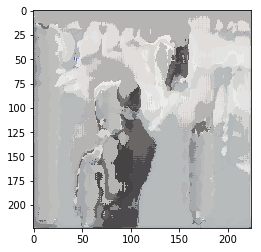

In [100]:
img = cv2.resize(cv2.imread('../../Dataset/camera4/JPEGImages/00015.jpg'), (224,224))
# img = cv2.resize(cv2.imread('../../sample2.jpg'), (224,224))
datav = torch.from_numpy( np.array([img.transpose( (2, 0, 1) ).astype('float32')/255.]) )
datav = Variable(datav)
output = model(datav)[0][0]
_, labels_pred = torch.max(output,0)
im_target_rgb = color.label2rgb(labels_pred.cpu().numpy(), img, kind = 'rgb')
plt.imshow(im_target_rgb)

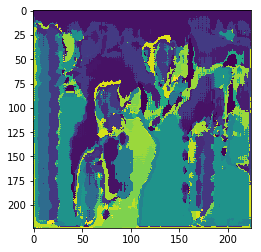

In [109]:
plt.imshow(labels_pred.cpu().numpy()%100)
plt.savefig('Wnet02.png')

In [111]:
g = graph.rag_mean_color(img, labels_pred.cpu().numpy()%100, mode='similarity')
labels2 = graph.cut_normalized(labels_pred.cpu().numpy()%100, g, thresh=0.01)
out2 = color.label2rgb(labels2, img, kind='avg')*2

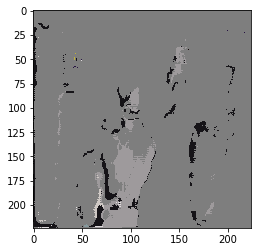

In [112]:
plt.imshow(out2)
plt.savefig('Wnet01.png')

In [113]:
torch.save(model.state_dict(), 'model.h5')